In [ ]:
# Articles
# https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [142]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import datetime as dt
from pandas.plotting import autocorrelation_plot

In [143]:
data = pd.read_csv("../data/state-daily-stats.csv", parse_dates=['date'])
data.drop(columns={"Unnamed: 0"}, inplace=True)

In [144]:
for index, row in data.iterrows():
    date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
    date2 = dt.datetime.strftime(date, "%m-%d-%Y")
    data.at[index, "date"] = date2

In [145]:
data["date"] = pd.to_datetime(data["date"])
daily_new_cases = pd.DataFrame(data[["date","daily_new_cases"]])
# daily_new_cases.set_index("date", inplace=True)

In [146]:
daily_new_cases = daily_new_cases[daily_new_cases["date"] >= dt.datetime(2020,3,1)]
for index, row in daily_new_cases.iterrows():
    date = row["date"]
    new_date = dt.datetime.strftime(date, "%m-%d-%Y")
    daily_new_cases.at[index, "date"] = new_date

In [147]:
daily_new_cases.set_index("date", inplace=True)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

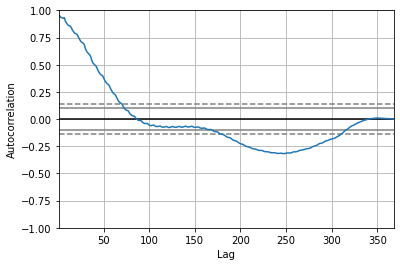

In [148]:
autocorrelation_plot(daily_new_cases)

In [149]:
log_daily_new_cases = pd.DataFrame(np.log(daily_new_cases.daily_new_cases))

<AxesSubplot:xlabel='date'>

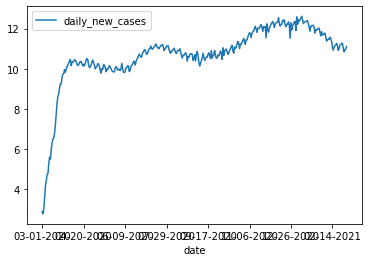

In [150]:
log_daily_new_cases.plot()

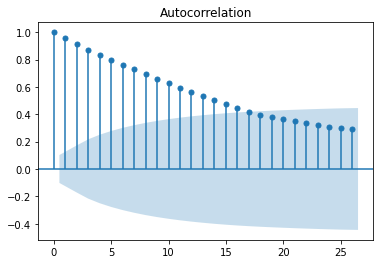

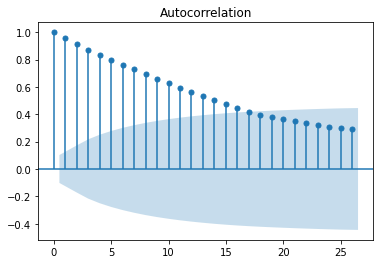

In [151]:
plot_acf(log_daily_new_cases)

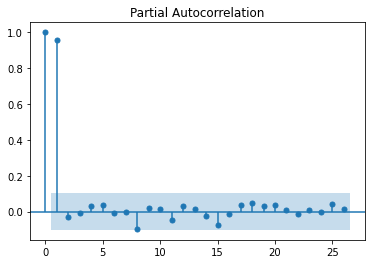

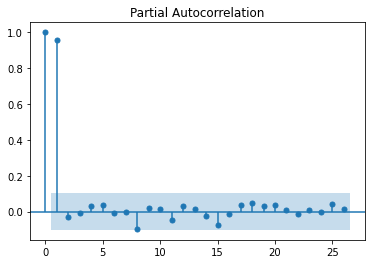

In [160]:
plot_pacf(log_daily_new_cases)

In [161]:
result = adfuller(log_daily_new_cases.daily_new_cases, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.3142798774658093
p-value: 0.014252105910300359


In [163]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

model = ARIMA(log_daily_new_cases.daily_new_cases, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.daily_new_cases   No. Observations:                  367
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 122.337
Method:                       css-mle   S.D. of innovations              0.173
Date:                Fri, 05 Mar 2021   AIC                           -234.674
Time:                        13:46:33   BIC                           -215.148
Sample:                    03-02-2020   HQIC                          -226.916
                         - 03-03-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0683      0.078      0.878      0.380      -0.084       0.221
ar.L1.D.daily_new_cases     0.9928      0.008    118.789      0.000       0.976       1.009


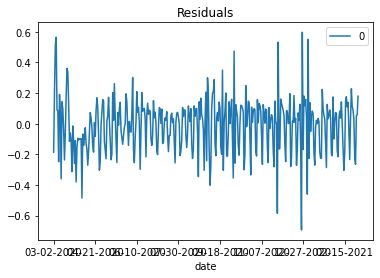

In [167]:
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals")
# residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

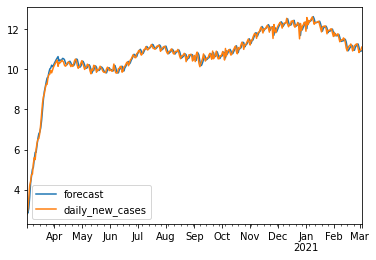

In [168]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [206]:
training = log_daily_new_cases[:276]
testing = log_daily_new_cases[276:]

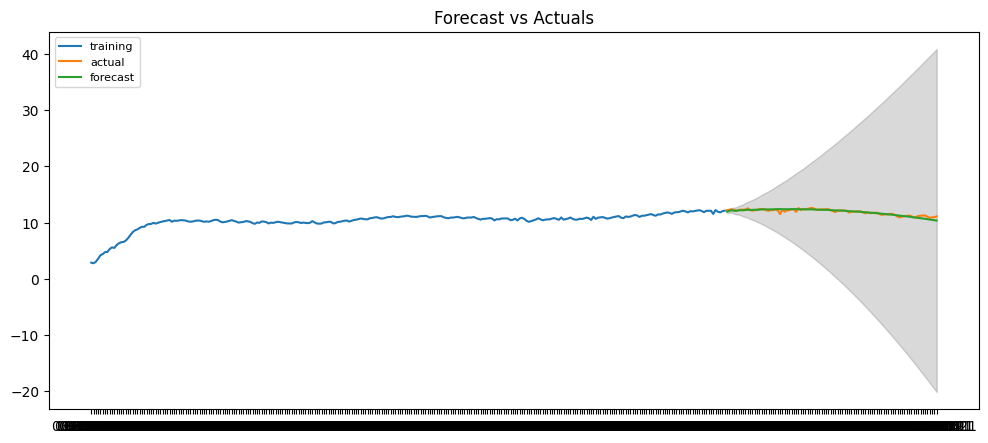

In [208]:
model = ARIMA(training, order=(5, 2, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(92, alpha=0.05)  

# Forecast
# fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=testing.index)
lower_series = pd.Series(conf[:, 0], index=testing.index)
upper_series = pd.Series(conf[:, 1], index=testing.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(testing, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [209]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D2.daily_new_cases   No. Observations:                  274
Model:                 ARIMA(5, 2, 2)   Log Likelihood                 146.914
Method:                       css-mle   S.D. of innovations              0.140
Date:                Fri, 05 Mar 2021   AIC                           -275.829
Time:                        14:07:31   BIC                           -243.311
Sample:                    03-03-2020   HQIC                          -262.777
                         - 12-01-2020                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0010      0.002     -0.538      0.591      -0.004       0.003
ar.L1.D2.daily_new_cases    -0.0122      0.060     -0.205      0.838      -0.129       0.105
ar.L2.D2.daily_new_cases    -0.4972      0.049    -10.080      0.000      -0.594      -0.401
ar.L3.D2.daily_new_cases    -0.4459      0.049     -9.064      0.000      -0.542      -0.349
ar.L4.D2.daily_new_cases    -0.3896      0.048     -8.201      0.000      -0.483      -0.296
ar.L5.D2.daily_new_cases    -0.5128      0.058     -8.858      0.000      -0.626      -0.399
ma.L1.D2.daily_new_cases    -1.2095      0.038    -31.763      0.000      -1.284      -1.135
ma.L2.D2.daily_new_cases     0.8111      0.053     15.422      0.000       0.708       0.914
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6285           -0.7897j            1.0093           -0.1430
AR.2            0.6285           +0.7897j            1.0093            0.1430
AR.3           -1.3108           -0.0000j            1.3108           -0.5000
AR.4           -0.3530           -1.1558j            1.2085           -0.2972
AR.5           -0.3530           +1.1558j            1.2085            0.2972
MA.1            0.7455           -0.8228j            1.1103           -0.1328
MA.2            0.7455           +0.8228j            1.1103            0.1328
-----------------------------------------------------------------------------
"""

In [210]:
import pmdarima as pm

ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
result = adfuller(cases_df['cases'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
df_log = np.log(cases_df)
plt.plot(df_log)

In [ ]:
rolling_mean = df_log.rolling(window=7).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
df_log_minus_mean

In [ ]:
result2 = adfuller(df_log_minus_mean['cases'])
print('ADF Statistic: {}'.format(result2[0]))
print('p-value: {}'.format(result2[1]))
print('Critical Values:')
for key, value in result2[4].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
autocorrelation_plot(df_log_minus_mean)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(np.log(cases_df.cases), lags=175, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.log(cases_df.cases), lags=175, ax=ax[1])
ax[0].set_xlim(0, 177)
ax[1].set_xlim(0, 177)
plt.show()

In [ ]:
sar = sm.tsa.statespace.SARIMAX(np.log(cases_df.cases), 
                                order=(1, 1, 2), 
                                seasonal_order=(2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
sar.summary()
# SARIMA(1, 1, 2),(2, 1, 1, 7)

In [ ]:
sar = sm.tsa.statespace.SARIMAX(np.log(cases_df.cases), 
                                order=(1, 1, 2), 
                                seasonal_order=(2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
sar.summary()
# SARIMA(1, 1, 2),(2, 1, 1, 7)

In [ ]:

# res = sar.resid
# fig,ax = plt.subplots(2,1,figsize=(15,8))
# fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
# fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
# ax[0].set_xlim(0, 52)
# ax[1].set_xlim(0, 52)
# plt.show()

In [ ]:
# import itertools

# # set parameter range
# p = range(0,3)
# q = range(1,3)
# d = range(1,2)
# s = range(7,8)

# # list of all parameter combos
# pdq = list(itertools.product(p, d, q))
# # same for seasonal variant
# seasonal_pdq = list(itertools.product(p, d, q, s))

In [ ]:
# import warnings
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(np.log(cases_df.cases),
#                                             order=param,
#                                             seasonal_order=param_seasonal)
#             results = mod.fit(max_iter = 50, method = 'powell')
            
#             print('----------------------------------------------------------------')
#             print('SARIMA{},{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
#             print('----------------------------------------------------------------')
#         except:
#             continue

In [ ]:
predictions = sar.get_forecast(steps = 30)

In [ ]:
predictions.plot()

# OLD

In [ ]:
for index, row in data.iterrows():
    date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
    date2 = dt.datetime.strftime(date, "%m-%d-%Y")
    data.at[index, "date"] = date2

In [ ]:
# data["date"] = pd.to_datetime(data["date"])

In [ ]:
data.info()

In [ ]:
cases_df = data[["date", "cases"]]

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(cases_df)

In [ ]:
training = data[data["date"] < "2021-02-01"]
training["date_index"] = training["date"]

In [ ]:
training.set_index("date_index", inplace=True)

In [ ]:
plt.figure(figsize=[21,7])
plt.plot(training['cases'])

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(np.log(training.cases), lags=170, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.log(training.cases), lags=170, ax=ax[1])
ax[0].set_xlim(0, 177)
ax[1].set_xlim(0, 177)
plt.show()

In [ ]:
training_seas = training.cases.diff(7)
training_diff = training.cases.diff()
training_both = training_seas.diff()

In [ ]:
training_both.fillna(0, inplace=True)

In [ ]:
plt.plot(training_both)

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(training_both)

In [ ]:
pvalue

In [ ]:
test[-10:]

In [ ]:
test_log = np.log(test)
test.plot()

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(np.log(data.cases), lags=175, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.log(data.cases), lags=175, ax=ax[1])
ax[0].set_xlim(0, 177)
ax[1].set_xlim(0, 177)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(train_both[8:])

In [ ]:
train2_seas = train2.meter_reading_scraped.diff(7)
train2_diff = train2.meter_reading_scraped.diff()
train_both = train_seas.diff()

In [ ]:
rolling_mean = test.rolling(window = 12).mean()
rolling_std = test.rolling(window = 12).std()
plt.plot(test, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()